# **Intel Image Classification Gamma**
---
### Intial setup for importing data 

In [1]:
from google.colab import files

uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [2]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json  # set permission

kaggle.json


In [15]:
!kaggle datasets download -d puneet6060/intel-image-classification
!unzip intel-image-classification

intel-image-classification.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  intel-image-classification.zip
replace seg_pred/seg_pred/10004.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace seg_pred/seg_pred/10005.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace seg_pred/seg_pred/10012.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [0]:
import os
import matplotlib.pyplot as plot
import cv2
import numpy as np
from sklearn.utils import shuffle

## Function to extract images from respective directories and perform standardization

In [0]:
def get_images(directory):
    Images = []
    Labels = []  # 0 for Building , 1 for forest, 2 for glacier, 3 for mountain, 4 for Sea , 5 for Street
    label = 0
    
    for labels in os.listdir(directory): #Main Directory where each class label is present as folder name.
        if labels == 'glacier': #Folder contain Glacier Images get the '2' class label.
            label = 2
        elif labels == 'sea':
            label = 4
        elif labels == 'buildings':
            label = 0
        elif labels == 'forest':
            label = 1
        elif labels == 'street':
            label = 5
        elif labels == 'mountain':
            label = 3

        for image_file in os.listdir(directory+labels): #Extracting the file name of the image from Class Label folder
            image = cv2.imread(directory+labels+r'/'+image_file) #Reading the image (OpenCV)
            image = cv2.resize(image,(224,224)) #Resize the image, Some images are different sizes. (Resizing is very Important)
            Images.append(image)
            Labels.append(label)
    
    return shuffle(Images,Labels,random_state=817328462) #Shuffle the dataset you just prepared.

def get_classlabel(class_code):
    labels = {2:'glacier', 4:'sea', 0:'buildings', 1:'forest', 5:'street', 3:'mountain'}
    
    return labels[class_code]

In [0]:
Images, Labels = get_images('../content/seg_train/seg_train/') #Extract the training images from the folders.
Images = np.array(Images) #converting the list of images to numpy array.
Labels = np.array(Labels)

### Inspecting the downloaded samples we can see we have 14034 samples in our training set

In [7]:
print("Shape of Images:",Images.shape)
print("Shape of Labels:",Labels.shape)

Shape of Images: (14034, 224, 224, 3)
Shape of Labels: (14034,)


## Exploring some of the pictures from our training set

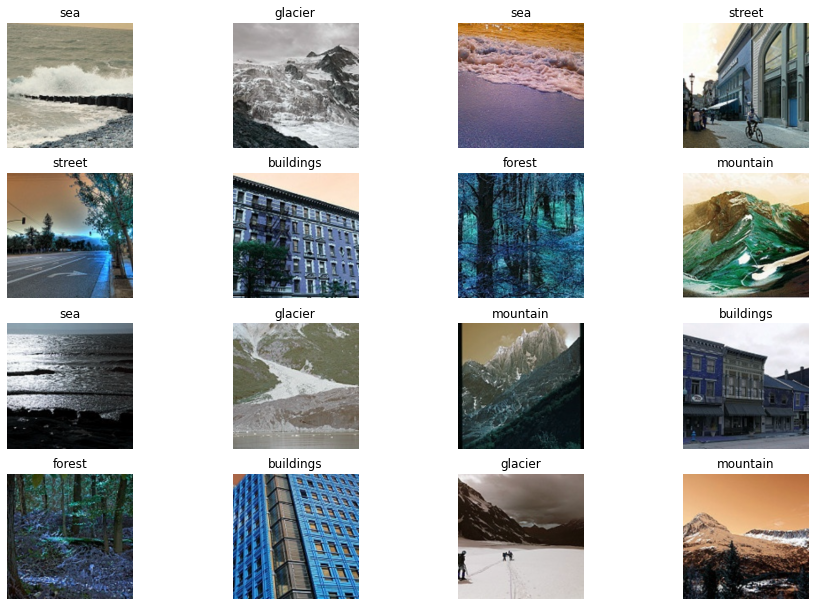

In [8]:
from random import randint
f,ax = plot.subplots(4,4) 
f.subplots_adjust(0,0,2,2)
for i in range(0,4,1):
    for j in range(0,4,1):
        rnd_number = randint(0,len(Images))
        ax[i,j].imshow(Images[rnd_number])
        ax[i,j].set_title(get_classlabel(Labels[rnd_number]))
        ax[i,j].axis('off')

# Lets builds the model ! 

In [0]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow.keras.optimizers as Optimizer
from tensorflow.keras.callbacks import EarlyStopping

---
### I willl be using MobileNetV2 as the base classifier pre-loaded with weights from Imagenet, this would save us valuable training time and make use of the pre-trained layers in MovileNetV2 which was trained on lots more data and has learned to identify key features from the Image

In [10]:
# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=(224,224,3),
                                               include_top=False,
                                               weights='imagenet')

9412608/9406464 [==============================] - 0s 0us/step


In [0]:
base_model.trainable = False

### Adding 2 dense layers followed by a dropout layer to introduced some regularization and finally a 6 output softmax dense layer to perform the required classification task

In [0]:
flatten_layer = Flatten()
dense_layer_1 = Dense(150, activation='relu')
dense_layer_2 = Dense(100, activation='relu')
dropout_layer = Dropout(0.3)
prediction_layer = Dense(6, activation='softmax')

In [13]:
model = Sequential([
                    base_model,
                    flatten_layer, 
                    dense_layer_1,
                    dense_layer_2,
                    dropout_layer,
                    prediction_layer])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
flatten (Flatten)            (None, 62720)             0         
_________________________________________________________________
dense (Dense)                (None, 150)               9408150   
_________________________________________________________________
dense_1 (Dense)              (None, 100)               15100     
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 606       
Total params: 11,681,840
Trainable params: 9,423,856
Non-trainable params: 2,257,984
_____________________________________

In [0]:
model.compile(optimizer=Optimizer.Adam(lr=0.0001),loss='sparse_categorical_crossentropy',metrics=['accuracy'])

### Lets train the new modified model with a earlystoppingcallback so we dont overfit to the training data

In [16]:
callback = EarlyStopping(monitor='loss', patience=3)
trained = model.fit(Images,Labels,epochs=50,validation_split=0.30,callbacks = [callback])

Epoch 1/50
307/307 [==============================] - 13s 41ms/step - loss: 0.8467 - accuracy: 0.6880 - val_loss: 0.6398 - val_accuracy: 0.7609
Epoch 2/50
307/307 [==============================] - 12s 38ms/step - loss: 0.5401 - accuracy: 0.8064 - val_loss: 0.6017 - val_accuracy: 0.7787
Epoch 3/50
307/307 [==============================] - 12s 38ms/step - loss: 0.4037 - accuracy: 0.8544 - val_loss: 0.5927 - val_accuracy: 0.7913
Epoch 4/50
307/307 [==============================] - 12s 38ms/step - loss: 0.2921 - accuracy: 0.8965 - val_loss: 0.5641 - val_accuracy: 0.8076
Epoch 5/50
307/307 [==============================] - 12s 38ms/step - loss: 0.2118 - accuracy: 0.9236 - val_loss: 0.6125 - val_accuracy: 0.7998
Epoch 6/50
307/307 [==============================] - 12s 38ms/step - loss: 0.1606 - accuracy: 0.9426 - val_loss: 0.6565 - val_accuracy: 0.7977
Epoch 7/50
307/307 [==============================] - 12s 38ms/step - loss: 0.1119 - accuracy: 0.9605 - val_loss: 0.6892 - val_accuracy:

## Lets see how our model has performed

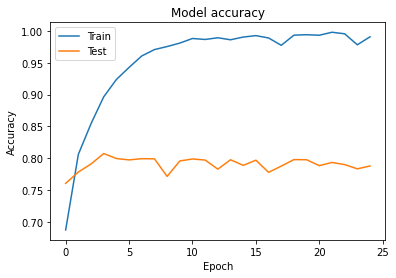

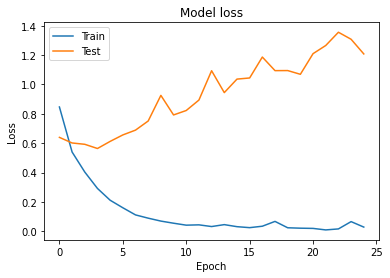

In [17]:
plt.plot(trained.history['accuracy'])
plt.plot(trained.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(trained.history['loss'])
plt.plot(trained.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

### We have managed to achieve ~ 98 % accuracy on the training set, however only ~80% on the test set (this seems to be constant with increasing epochs, so more regularization or a model developed from scratch / or trained just for this specific task might improve the results) 

In [18]:
test_images,test_labels = get_images('../content/seg_test/seg_test/')
test_images = np.array(test_images)
test_labels = np.array(test_labels)
model.evaluate(test_images,test_labels, verbose=1)

94/94 [==============================] - 2s 27ms/step - loss: 1.1813 - accuracy: 0.7947


[1.1812760829925537, 0.7946666479110718]

## To try pictures of our own

In [0]:
ind_to_label = {
    0 : 'Buildings',
    1 : 'Forest',
    2 : 'Glacier',
    3 : 'Mountain',
    4 : 'Sea',
    5 : 'Street'   
}

Saving 135.jpg to 135.jpg

 ____________________________________________________________________________________________________


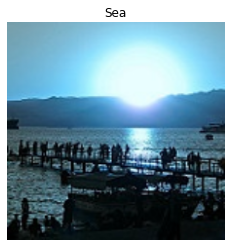

In [29]:
import matplotlib.pyplot as plt
from keras.preprocessing import image
uploaded = files.upload()
print('\n', '_'*100)

for fn in uploaded.keys():
  # predicting images
  path = '/content/' + fn
  img = image.load_img(path, target_size=(224, 224))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images)
  pred_prob = model.predict(images).reshape(6)
  ind = np.argmax(classes)

  image = cv2.imread(path) #Reading the image (OpenCV)
  image = cv2.resize(image,(224,224))
  image = np.array(image)
  plt.imshow(image)
  Labeldata = ind_to_label[ind]
  plt.title(Labeldata)
  plt.axis("off")


<BarContainer object of 6 artists>

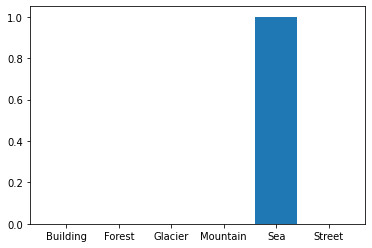

In [31]:
plt.bar(['Building','Forest','Glacier','Mountain','Sea','Street'],pred_prob)

## Finally lets run the model on the unlabelled data and visualize some of the results 

In [33]:
pred_images,no_labels = get_images('../content/seg_pred/')
pred_images = np.array(pred_images)
pred_images.shape

(7301, 224, 224, 3)

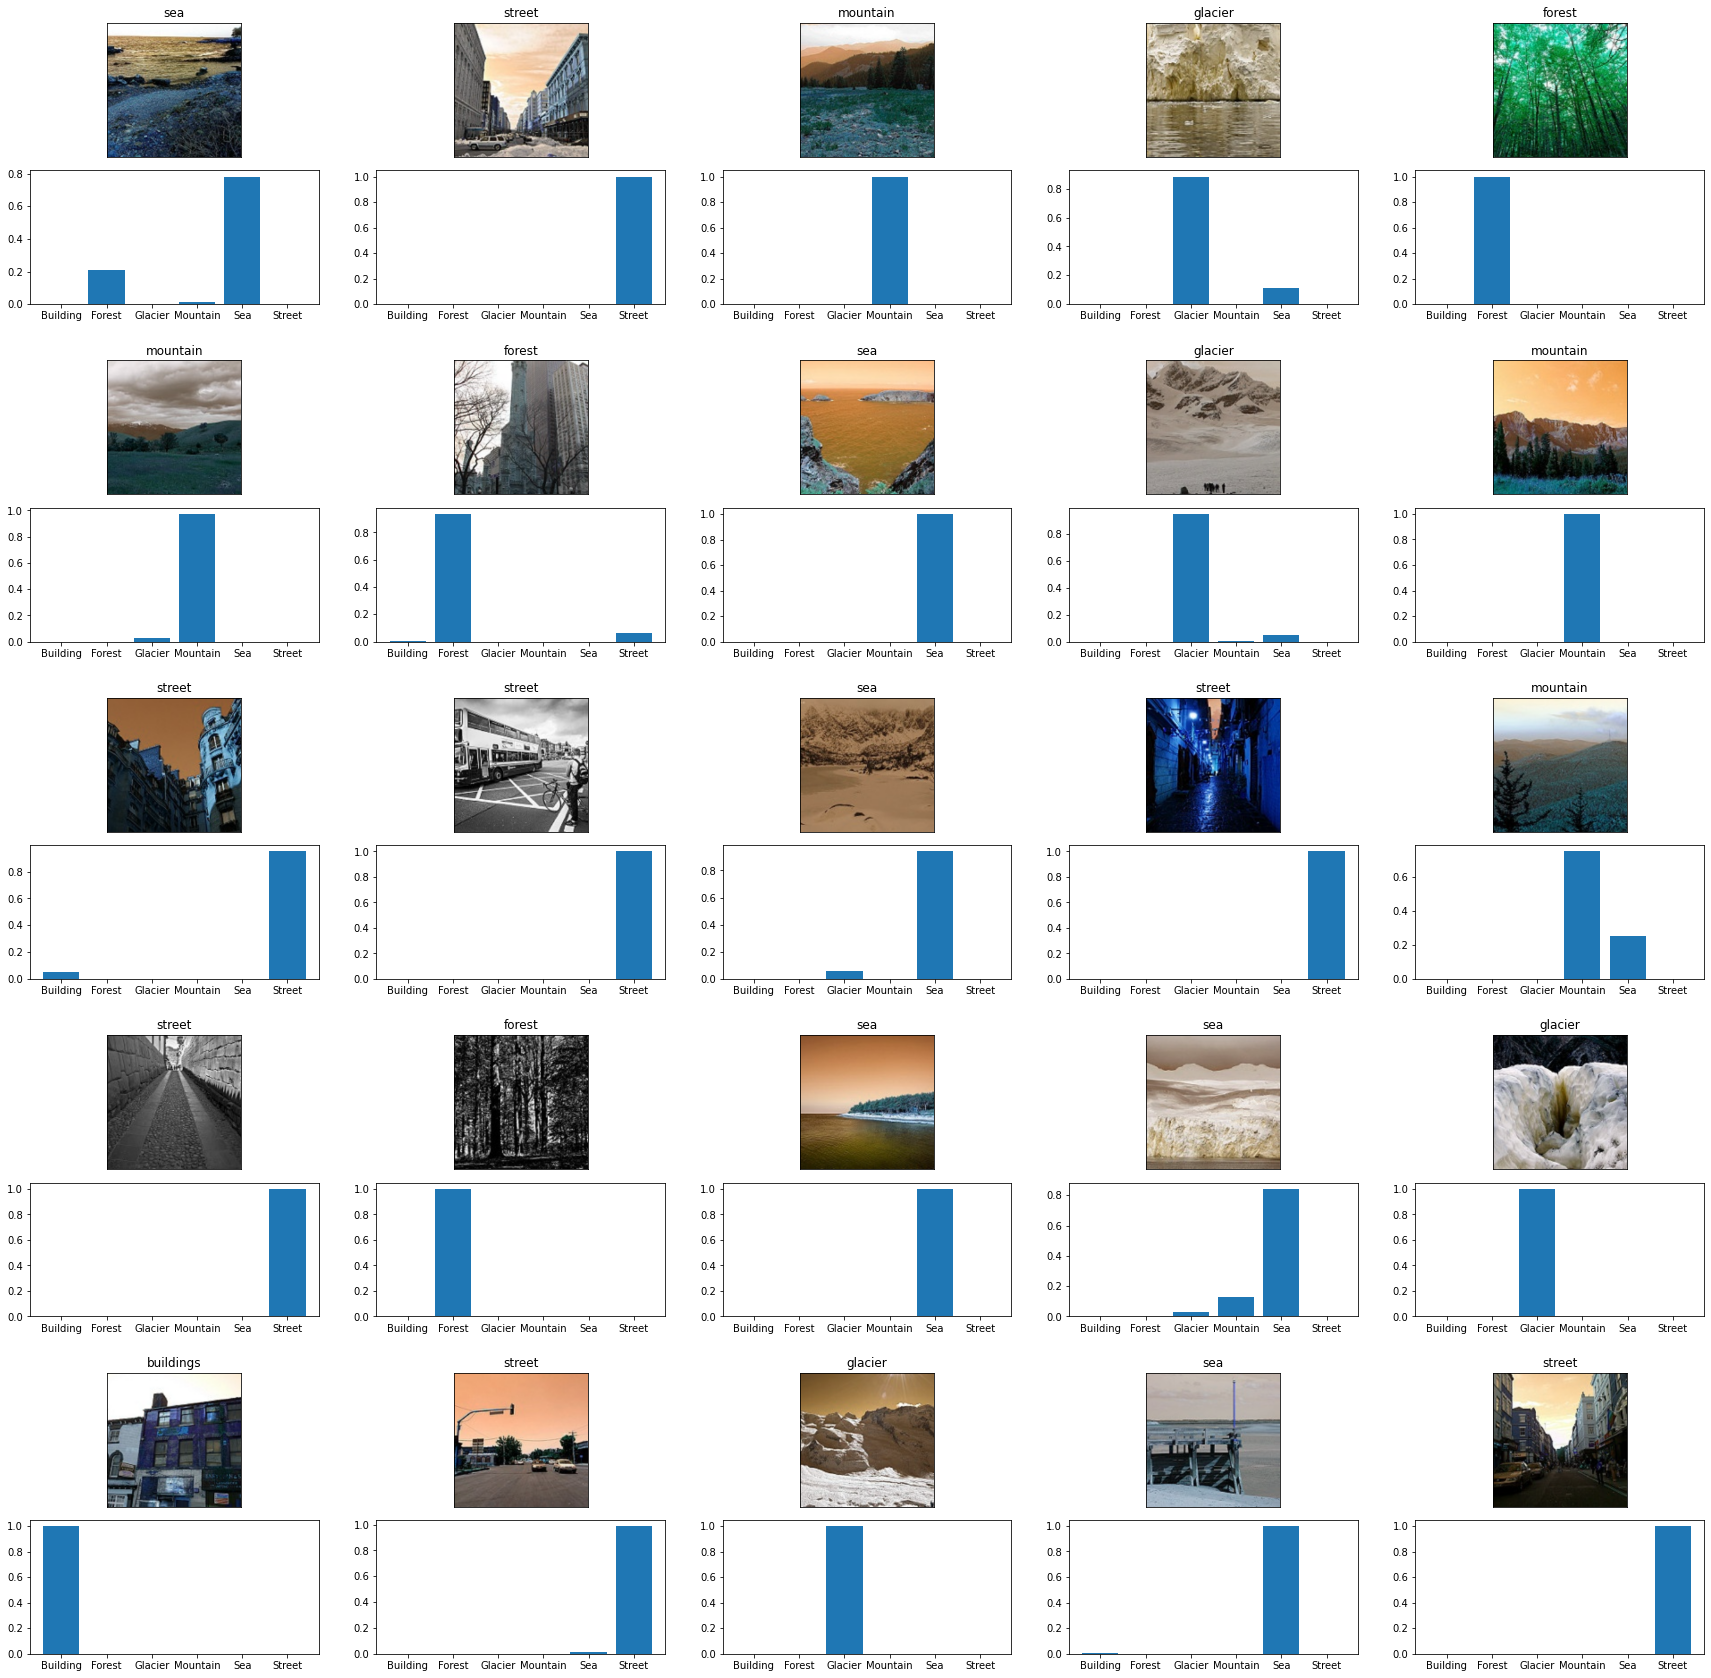

In [36]:
import matplotlib.gridspec as gridspec
fig = plot.figure(figsize=(30, 30))
outer = gridspec.GridSpec(5, 5, wspace=0.2, hspace=0.2)

for i in range(25):
    inner = gridspec.GridSpecFromSubplotSpec(2, 1,subplot_spec=outer[i], wspace=0.1, hspace=0.1)
    rnd_number = randint(0,len(pred_images))
    pred_image = np.array([pred_images[rnd_number]])
    pred_class = get_classlabel(model.predict_classes(pred_image)[0])
    pred_prob = model.predict(pred_image).reshape(6)
    for j in range(2):
        if (j%2) == 0:
            ax = plot.Subplot(fig, inner[j])
            ax.imshow(pred_image[0])
            ax.set_title(pred_class)
            ax.set_xticks([])
            ax.set_yticks([])
            fig.add_subplot(ax)
        else:
            ax = plot.Subplot(fig, inner[j])
            ax.bar(['Building','Forest','Glacier','Mountain','Sea','Street'],pred_prob)
            fig.add_subplot(ax)


fig.show()